# $12^{th}$ excercises - 12.1: Classification of images with a Dense neural network
## Notebook setup
#### Used libraries

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Nadam, Adagrad, Adadelta, Adamax


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#### Functions

In [ ]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_model(opt_function):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt_function,
                  metrics=['acc'])
    return model

def TestOptimizers(epochs):
    batch_size = 32 #servono per stochastic gradient descent

    for label,f in optimizers.items():
        print("Optimizer: ",label)
        model_DNN=compile_model(f)
    
        history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test))
        
        print("Storing model and history")
        path = "store/121-"+label+"-"
        path_history = path+"history.csv"
        path_model = path+"model.tf"
        
        model_DNN.save(filepath=path_model, include_optimizer=True)  
        df  = pd.DataFrame(history.history) 
        with open(path_history, mode='w') as file:
            df.to_csv(file)
        print()



In [4]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

## The excercise
We want to face a problem of image recognition using a dense neural network as those seen in the excercises 11. In particular we are going to train a dense neural network (DNN) with the images of digits from 0 to 9 contained in the minst database.

Let's first build the datasets

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('X_train shape:', x_train.shape)
print('Y_train shape:', y_train.shape)
print()
print('X_test shape:', x_test.shape)
print('Y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)

X_test shape: (10000, 28, 28)
Y_test shape: (10000,)


Taken as they are the images and their label are not suited to be fed in a neural network. We need to reshape the images and convert the label to an array where all elements are 0 except for the element indicized by the label which is 1.

In [13]:
# reshape data, it could depend on Keras backend
X_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
X_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(y_train, num_classes) #inizialmente le label sono la cifra, lo voglio trasformare in vettore di bit di cui quello acceso è quello con indice la cifra (cioè quello che sarà output rete)
Y_test = keras.utils.to_categorical(y_test, num_classes)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)

Y_train shape: (60000, 10)
Y_test shape: (10000, 10)


Now we can train our DNN. We will test different optimziers.

In [9]:
optimizers = {"SGD" : SGD(), 
              "Adam" : Adam(), 
              "Nadam" : Nadam(), 
              "Adagrad" : Adagrad()}

Initially we tested also the Adadelta optimizer but its loss was higher than that of the others and hid some interesitng behaviours of Adam and Nadam. Since it takes a while to complete, the execution of the test is disabled by default. To execute it, set `RERUN` to `True`

In [10]:
RERUN = False
Nepochs = 20

if(RERUN):
    TestOptimizers(Nepochs)

313/313 [==============================] - 2s 5ms/step - loss: 0.2077 - acc: 0.9413


,Optimizer,Test loss,Test accuracy,Training speed (s/epoch)
0,SGD,0.074275,0.9759,15-19
0,Adam,0.135038,0.9811,18-21
0,Nadam,0.126738,0.9813,37-43
0,Adagrad,0.207676,0.9413,17-23


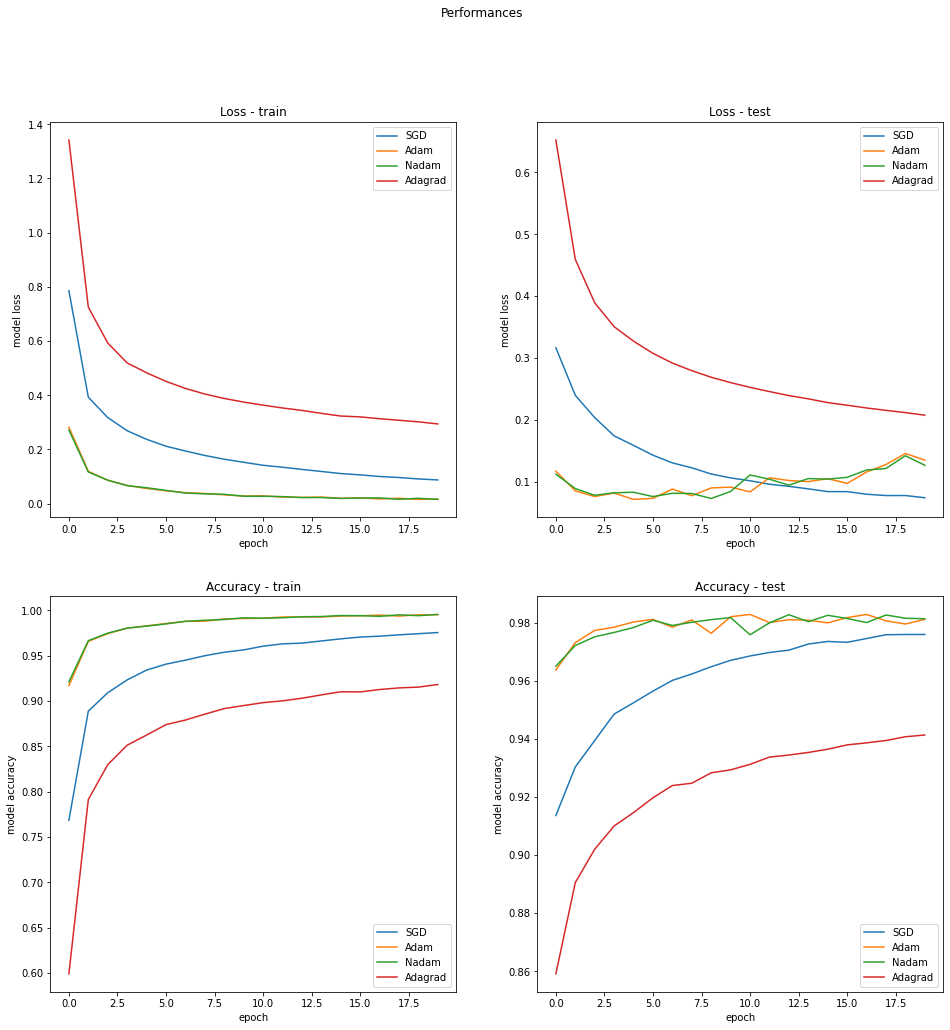

In [12]:
speed = {"SGD"       :  "15-19", 
         "Adam"      :  "18-21",
         "Nadam"     :  "37-43",
         "Adagrad"   :  "17-23"}

df = pd.DataFrame(columns = ["Optimizer", "Test loss", "Test accuracy", "Training speed (s/epoch)"])


plt.figure(figsize=(16, 16))
plt.suptitle("Performances")


for label in optimizers.keys():
    path = "store/121-"+label+"-"
    model_DNN=load_model(path+"model.tf")
    history = pd.read_csv(path+"history.csv")
    
    score = model_DNN.evaluate(X_test, Y_test, verbose=1)
    newrow = pd.DataFrame([{"Optimizer"                :  label, 
                            "Test loss"                :  score[0], 
                            "Test accuracy"            :  score[1],
                            "Training speed (s/epoch)" :  speed[label]}])
    df = pd.concat([df,newrow])
    
    plt.subplot(2, 2, 1)
    plt.plot(range(0, Nepochs), history.loc[:,"loss"], label=label)
    plt.subplot(2, 2, 2)
    plt.plot(range(0, Nepochs), history.loc[:,"val_loss"], label=label)
    plt.subplot(2, 2, 3)
    plt.plot(range(0, Nepochs), history.loc[:,"acc"], label=label)
    plt.subplot(2, 2, 4)
    plt.plot(range(0, Nepochs), history.loc[:,"val_acc"], label=label)
    
display(df)

plt.subplot(2, 2, 1)
plt.xlabel('epoch')
plt.ylabel('model loss')
plt.title('Loss - train')
plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('epoch')
plt.ylabel('model loss')
plt.title('Loss - test')
plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('epoch')
plt.ylabel('model accuracy')
plt.title('Accuracy - train')
plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('epoch')
plt.ylabel('model accuracy')
plt.title('Accuracy - test')
plt.legend()

plt.show()


Adam and Nadam performances are almost the same provided Nadam is much slower than Adam. Adagard has the best performances, so we will focus only on SGD and ADAM. We can notice how after 10 epochs SGD has a lower loss on the test dataset than ADAM, while ADAM accuracy is always better. The minimum in ADAM loss could mean that we are entering in an overfitting region: for this reason we decide to use ADAM in the following excercise, reducing the number of epochs to 10. 